Load the pre-trained neural network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import nn_utils

torch.cuda.empty_cache()

PATH = './nn-models/cifar10-nn-model'

net = nn_utils.Net()
net.load_state_dict(torch.load(PATH))
net.to(device=nn_utils.DEVICE)

# nn_utils.test_nn(net=net)


Files already downloaded and verified
Files already downloaded and verified


Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm6): BatchNorm2d(64, eps=1e-05,

Our optimization algorithm

In [2]:
import numpy as np
import random
import operator
import math

def calculate_fitness(position, mini_batch_num):
    # put the parameters in the neural network 
    parameters = torch.as_tensor(position, dtype=torch.float32, device=nn_utils.DEVICE)
    net.out.weight = torch.nn.Parameter(data=parameters[0:640].reshape(10, 64))
    net.out.bias = torch.nn.Parameter(data=parameters[640:650])
   
    with torch.no_grad():
        images = ALL_IMAGES[mini_batch_num].to(nn_utils.DEVICE)
        labels = ALL_LABELS[mini_batch_num].to(nn_utils.DEVICE)

        preds = net(images) # forward mini-batch
        loss = F.cross_entropy(preds, labels) # calculate loss

    return loss.item()

def calculate_mass(fitness_values, mass_list):
    best = min(fitness_values)
    worst = max(fitness_values)

    for i in range(0, MU):
        mass_list[i] = (fitness_values[i] - worst) / (best - worst)

    mass_sum = sum(mass_list)
    for i in range(0, MU):
        mass_list[i] = mass_list[i] / mass_sum
    
    return mass_list

def calculate_acceleration(positions, mass_list, gen, gravitational_constant):
    kbest = 2 + (1 - gen / N_GENERATIONS) * (100 - 2)
    kbest = round(MU * kbest / 100)
    kbest = int(kbest)

    ds = sorted(range(len(mass_list)), key=lambda k: mass_list[k], reverse=True)

    force = np.zeros((MU, N_DIMENSIONS))
    for i in range(0, MU):
        for ii in range(0, kbest):
            j = ds[ii]
            if j != i:
                r = np.linalg.norm(positions[i,:]-positions[j,:])
                for d in range(0, N_DIMENSIONS):
                    rand = random.random()
                    force[i, d] = force[i, d] + rand * (mass_list[j]) * ((positions[j,d]-positions[i,d]) / (r + np.finfo(float).eps))

    acceleration = np.zeros((MU, N_DIMENSIONS))
    for i in range(0, MU):
        for d in range(0, N_DIMENSIONS):
            acceleration[i,d] = gravitational_constant * force[i,d]
    
    return acceleration

def update_particle(positions, velocities, acceleration):
    for i in range(0, MU):
        for j in range (0, N_DIMENSIONS):
            rand = random.random()
            velocities[i,j] = rand * velocities[i,j] + acceleration[i,j]
            positions[i,j] = positions[i,j] + velocities[i,j]

    return positions, velocities

nn_utils.freeze_parameters(net=net)

N_DIMENSIONS = sum(param.numel() for param in net.out.parameters())
MIN_BOUND = 0.0
MAX_BOUND = 1.0
EPSILON = 0.0
GAMMA = 1.0
N_GENERATIONS = 50
MU = 200
GRAVITY = 100 # modified from 100
ALPHA = 20 # modified from 20 (learning rate)

# store all the training dataset in a single list
ALL_IMAGES = []
ALL_LABELS = []
for images, labels in nn_utils.TRAINLOADER:
    ALL_IMAGES.append(images)
    ALL_LABELS.append(labels)

def mgsa():
    # initialize
    velocities = np.zeros((MU, N_DIMENSIONS)) # velocity per particle per dimension
    fitness_values = np.zeros(MU) # fitness value per particle
    mass_list = np.zeros(MU) # mass per particle
    positions = np.random.uniform(0, 1, (MU,N_DIMENSIONS)) * (MAX_BOUND - MIN_BOUND) + MIN_BOUND 
    g_best_fitness = float('inf')
    g_best_position = None
    tol = 0.01

    mgsa_convergence = []

    for gen in range(0, N_GENERATIONS):
        # evaluate all the positions in the population
        for i in range(0, MU):
            positions[i,:] = np.clip(positions[i,:], MIN_BOUND, MAX_BOUND)
            fitness_values[i] = calculate_fitness(position=positions[i,:], mini_batch_num=gen % len(ALL_IMAGES))
        
        # assign the best position and best fitness value for the first iteration
        if not g_best_position:
            g_best_position = list(positions[fitness_values.argmin(),:])
            g_best_fitness = min(fitness_values)

        rule_1 = g_best_fitness - min(fitness_values) > EPSILON
        rule_2 = np.linalg.norm(g_best_position - positions[fitness_values.argmin(),:]) > GAMMA

        if rule_1 and rule_2:
            print(f'Generation {gen} -- Starting local search ...')
            curr_position = list(positions[fitness_values.argmin(),:])
            prev_position = None
            prev_loss = None

            # put the parameters in the neural network 
            parameters = torch.as_tensor(curr_position, dtype=torch.float32, device=nn_utils.DEVICE)
            net.out.weight = torch.nn.Parameter(data=parameters[0:640].reshape(10, 64))
            net.out.bias = torch.nn.Parameter(data=parameters[640:650])

            # select the local search method
            optimizer = torch.optim.Rprop(net.parameters())

            while True:
                # loop over the dataset by mini-batch
                for mini_batch in nn_utils.TRAINLOADER:
                    images = mini_batch[0].to(nn_utils.DEVICE)
                    labels = mini_batch[1].to(nn_utils.DEVICE)

                    optimizer.zero_grad() # zero the parameter gradients

                    preds = net(images) # forward mini-batch

                    loss = F.cross_entropy(preds, labels) # calculate loss
                    loss.backward() # calculate gradients with respect to each parameter
                    optimizer.step() # update parameters

                    mgsa_convergence.append(float(loss.item()))

                    weight = net.out.weight.reshape((10, 64)).flatten().tolist()
                    bias = net.out.bias.flatten().tolist()

                    curr_position = list(weight + bias)

                    if not prev_position or not prev_loss:
                        prev_position = list(weight + bias)
                        prev_loss = float(loss.item())
                    else:
                        # check stopping criteria
                        euclidean_distance = np.linalg.norm(np.array(curr_position) - np.array(prev_position)) 
                        loss_diff = np.abs(float(loss.item()) - prev_loss)
                        criteria_1 = euclidean_distance < tol
                        criteria_2 = loss_diff < tol
                        if criteria_1 and criteria_2:
                            break
                        prev_position = list(weight + bias)
                        prev_loss = float(loss.item())
                
                if criteria_1 and criteria_2:
                    break
            
            print(f'Generation {gen} -- Stopping local search')

            # extract the parameters from the last layer of the neural network
            weight = net.out.weight.reshape((10, 64)).flatten().tolist()
            bias = net.out.bias.flatten().tolist()

            # update the current best position and current best fitness value
            velocities[fitness_values.argmin(),:] =  list(map(operator.sub, list(weight + bias), g_best_position))
            positions[fitness_values.argmin(),:] = list(weight + bias)
            fitness_values[fitness_values.argmin()] = float(loss.item())

            # update the global best position and global best fitness value
            g_best_position = list(weight + bias)
            g_best_fitness = float(loss.item())
            
            # update tolerance
            tol = tol / 10

        elif g_best_fitness > min(fitness_values):
            print('Global best updated without starting local search ...')
            g_best_fitness = min(fitness_values)
            g_best_position = list(positions[fitness_values.argmin(),:]) 

        # update decaying gravitational constant
        gravitational_constant = GRAVITY * (np.exp(-ALPHA * float(gen) / N_GENERATIONS))

        # calculate mass
        mass_list = calculate_mass(fitness_values=fitness_values, mass_list=mass_list)

        # calculate acceleration
        acceleration = calculate_acceleration(positions=positions, mass_list=mass_list, gen=gen, gravitational_constant=gravitational_constant)

        # update position and velocity
        positions, velocities = update_particle(positions=positions, velocities=velocities, acceleration=acceleration)

        # track generation
        mgsa_convergence.append(g_best_fitness)
        print(f'Generation: {gen} -- Loss: {g_best_fitness}')
        
    return positions, g_best_position, mgsa_convergence

positions, best_position, mgsa_convergence = mgsa()

Generation: 0 -- Loss: 7.521261692047119
Generation: 1 -- Loss: 7.521261692047119
Generation: 2 -- Loss: 7.521261692047119
Generation: 3 -- Loss: 7.521261692047119
Generation 4 -- Starting local search ...
Generation 4 -- Stopping local search
Generation: 4 -- Loss: 0.07959018647670746
Generation: 5 -- Loss: 0.07959018647670746
Generation: 6 -- Loss: 0.07959018647670746
Generation: 7 -- Loss: 0.07959018647670746
Generation: 8 -- Loss: 0.07959018647670746
Generation: 9 -- Loss: 0.07959018647670746
Generation: 10 -- Loss: 0.07959018647670746
Generation: 11 -- Loss: 0.07959018647670746
Generation: 12 -- Loss: 0.07959018647670746
Generation: 13 -- Loss: 0.07959018647670746
Generation: 14 -- Loss: 0.07959018647670746
Generation: 15 -- Loss: 0.07959018647670746
Generation: 16 -- Loss: 0.07959018647670746
Generation: 17 -- Loss: 0.07959018647670746
Generation: 18 -- Loss: 0.07959018647670746
Generation: 19 -- Loss: 0.07959018647670746
Generation: 20 -- Loss: 0.07959018647670746
Generation: 21

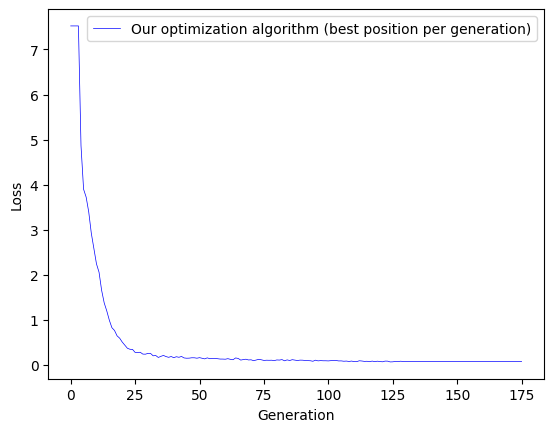

In [3]:
plt.plot(np.array(mgsa_convergence), color='b', linewidth=0.5, label='Our optimization algorithm (best position per generation)')
plt.ylabel('Loss')
plt.xlabel('Generation')
plt.legend()
plt.show()

In [4]:
# put parameters back into the neural network
parameters = torch.as_tensor(best_position, dtype=torch.float32, device=nn_utils.DEVICE)
net.out.weight = torch.nn.Parameter(data=parameters[0:640].reshape(10, 64))
net.out.bias = torch.nn.Parameter(data=parameters[640:650])

# test the neural network
mgsa_accuracy = nn_utils.test_nn(net=net)
mgsa_accuracy

print(mgsa_accuracy)

75


Population-based algorithm (Genetic algorithm)

In [5]:
import random
import numpy as np
from deap import base, creator, tools
import matplotlib.pyplot as plt

nn_utils.freeze_parameters(net=net)

MIN_BOUND = 0.0
MAX_BOUND = 1.0
N_DIMENSIONS = sum(param.numel() for param in net.out.parameters())
N_BITS = 10
N_GENERATIONS = len(mgsa_convergence)
MU = 200
CX_PB = 0.9
UNIFORM_CX_PB = 0.5
MUTATE_PB = 0.1
MUTATE_FLIP_PB = 1.0 / (N_DIMENSIONS * N_BITS)
ELITISM = 5

# store all the training dataset in a single list
ALL_IMAGES = []
ALL_LABELS = []
for images, labels in nn_utils.TRAINLOADER:
    ALL_IMAGES.append(images)
    ALL_LABELS.append(labels)

def decode(individual):
    real_numbers = []
    for i in range(N_DIMENSIONS):
        chromosome = individual[i*N_BITS:(i+1)*N_BITS]
        bit_string = ''.join(map(str, chromosome))
        num_as_int = int(bit_string, 2) # convert to int from base 2 list
        num_in_range = MIN_BOUND + (MAX_BOUND - MIN_BOUND) * num_as_int / 2**N_BITS
        real_numbers.append(num_in_range)

    return real_numbers

def calculate_fitness(individual, mini_batch_num):
    # put the parameters into the neural network
    parameters = decode(individual=individual)
    parameters = torch.as_tensor(parameters, dtype=torch.float32, device=nn_utils.DEVICE)
    net.out.weight = torch.nn.Parameter(data=parameters[0:640].reshape(10, 64))
    net.out.bias = torch.nn.Parameter(data=parameters[640:650])

    with torch.no_grad():
        images, labels = ALL_IMAGES[mini_batch_num].to(nn_utils.DEVICE), ALL_LABELS[mini_batch_num].to(nn_utils.DEVICE)

        preds = net(images) # forward mini-batch
        loss = F.cross_entropy(preds, labels) # calculate loss

    return loss.item(),

creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register('attr_bool', random.randint, 0, 1)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, N_BITS*N_DIMENSIONS)
toolbox.register('generate_population', tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', calculate_fitness)
toolbox.register('crossover', tools.cxUniform, indpb=UNIFORM_CX_PB)
toolbox.register('mutate', tools.mutFlipBit, indpb=MUTATE_FLIP_PB)
toolbox.register('select', tools.selTournament, fit_attr='fitness')

def ga():
    # track the performance
    ga_convergence = []

    # generate initial random population of individuals (parameters)
    population = toolbox.generate_population(n=MU)

    # evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population, np.zeros(len(population), dtype=int)))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # begin the generational process
    for gen in range(0, N_GENERATIONS):

        # select the next generation individuals
        offspring = tools.selBest(population, ELITISM) + toolbox.select(population, len(population)-ELITISM, 2)
        offspring = list(map(toolbox.clone, offspring))
        
        # crossover make pairs of all (even, odd) in offspring
        for ind1, ind2 in zip(offspring[4::2], offspring[5::2]):
            if random.random() <= CX_PB:
                toolbox.crossover(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        # mutation
        for mutant in offspring:
            if random.random() <= MUTATE_PB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind, np.full(len(invalid_ind), gen % len(ALL_IMAGES), dtype=int))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # population is entirely replaced by the offspring
        population[:] = offspring

        # track generation
        fits = [ind.fitness.values[0] for ind in population]
        ga_convergence.append(min(fits))

        print(f'Generation: {gen} -- Loss: {ga_convergence[-1]}')

    return population, ga_convergence
        
population, ga_convergence = ga()

Generation: 0 -- Loss: 6.708332538604736
Generation: 1 -- Loss: 6.708332538604736
Generation: 2 -- Loss: 6.116500377655029
Generation: 3 -- Loss: 6.116500377655029
Generation: 4 -- Loss: 6.116500377655029
Generation: 5 -- Loss: 6.116500377655029
Generation: 6 -- Loss: 5.9600019454956055
Generation: 7 -- Loss: 5.628560543060303
Generation: 8 -- Loss: 5.628560543060303
Generation: 9 -- Loss: 5.628560543060303
Generation: 10 -- Loss: 5.628560543060303
Generation: 11 -- Loss: 5.10498046875
Generation: 12 -- Loss: 5.10498046875
Generation: 13 -- Loss: 4.959288120269775
Generation: 14 -- Loss: 4.959288120269775
Generation: 15 -- Loss: 3.9633235931396484
Generation: 16 -- Loss: 3.9633235931396484
Generation: 17 -- Loss: 3.9633235931396484
Generation: 18 -- Loss: 3.3363826274871826
Generation: 19 -- Loss: 3.3363826274871826
Generation: 20 -- Loss: 3.3363826274871826
Generation: 21 -- Loss: 3.3363826274871826
Generation: 22 -- Loss: 3.3363826274871826
Generation: 23 -- Loss: 3.141040802001953
G

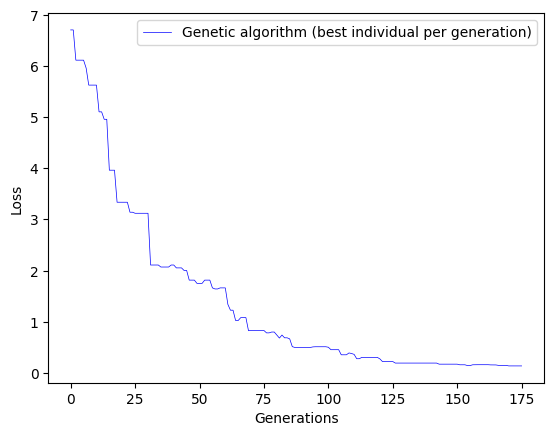

In [6]:
plt.plot(np.array(ga_convergence), color='b', linewidth=0.5, label='Genetic algorithm (best individual per generation)')
plt.ylabel('Loss')
plt.xlabel('Generations')
plt.legend()
plt.show()

In [7]:
# select the best individual
best_individual = tools.selBest(population, 1)[0]
# put parameters back into the neural network
best_individual_decoded = decode(best_individual)
parameters = torch.as_tensor(best_individual_decoded, dtype=torch.float32, device=nn_utils.DEVICE)
net.out.weight = torch.nn.Parameter(data=parameters[0:640].reshape(10, 64))
net.out.bias = torch.nn.Parameter(data=parameters[640:650])

# test the neural network
ga_accuracy = nn_utils.test_nn(net=net)
ga_accuracy

72

Gradient-based method (Adam)

In [35]:
nn_utils.freeze_parameters(net=net)

optimizer = torch.optim.RMSprop(net.parameters())
# adam_convergence = nn_utils.train_nn(net=net, epochs=len(mgsa_convergence), optimizer=optimizer)

adam_convergence = []

# loop over the dataset by mini-batch
it = 1
while True:
    for mini_batch in nn_utils.TRAINLOADER:
        if it == 175: break

        images = mini_batch[0].to(nn_utils.DEVICE)
        labels = mini_batch[1].to(nn_utils.DEVICE)

        optimizer.zero_grad() # zero the parameter gradients

        preds = net(images) # forward mini-batch

        loss = F.cross_entropy(preds, labels) # calculate loss
        loss.backward() # calculate gradients with respect to each weight
        optimizer.step() # update weights
        
        adam_convergence.append(loss.item())
        print(f'Iteration: {it} -- Loss: {adam_convergence[-1]}')
        it += 1
    if it == 175: break
    

Iteration: 1 -- Loss: 17.44654655456543
Iteration: 2 -- Loss: 16.467756271362305
Iteration: 3 -- Loss: 14.364994049072266
Iteration: 4 -- Loss: 19.173595428466797
Iteration: 5 -- Loss: 15.902002334594727
Iteration: 6 -- Loss: 15.427347183227539
Iteration: 7 -- Loss: 11.363787651062012
Iteration: 8 -- Loss: 9.232900619506836
Iteration: 9 -- Loss: 5.68366813659668
Iteration: 10 -- Loss: 4.108089923858643
Iteration: 11 -- Loss: 2.8071084022521973
Iteration: 12 -- Loss: 2.029092311859131
Iteration: 13 -- Loss: 1.7855335474014282
Iteration: 14 -- Loss: 1.5814162492752075
Iteration: 15 -- Loss: 1.7585821151733398
Iteration: 16 -- Loss: 1.3801627159118652
Iteration: 17 -- Loss: 1.1993765830993652
Iteration: 18 -- Loss: 0.9769097566604614
Iteration: 19 -- Loss: 1.0625537633895874
Iteration: 20 -- Loss: 0.9998972415924072
Iteration: 21 -- Loss: 0.9449567198753357
Iteration: 22 -- Loss: 1.1727581024169922
Iteration: 23 -- Loss: 0.8675392866134644
Iteration: 24 -- Loss: 0.926041305065155
Iteratio

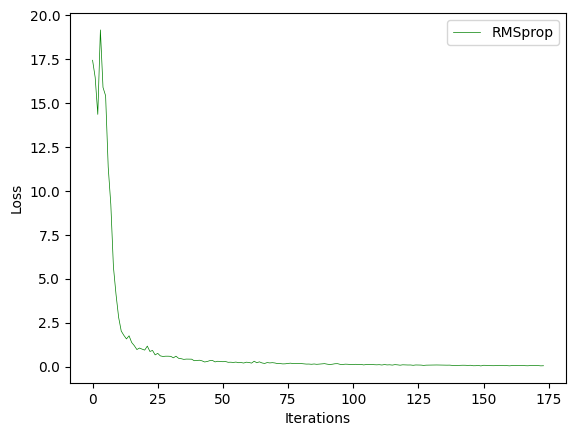

In [36]:
plt.plot(np.array(adam_convergence), color='g', label='RMSprop', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [37]:
# test the neural network
adam_accuracy = nn_utils.test_nn(net=net)
adam_accuracy

75

Final results

 =============== Accuracy =============== 
 RMSprop: 75%
 Genetic algorithm: 72%
 Our optimization algorithm: 75%


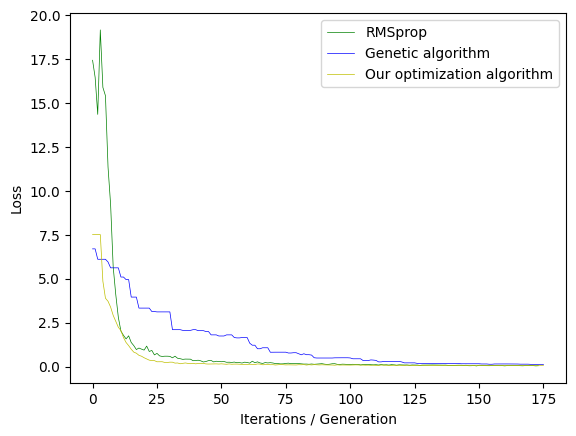

In [38]:
print(' =============== Accuracy =============== ')
print(f' RMSprop: {adam_accuracy}%')
print(f' Genetic algorithm: {ga_accuracy}%')
print(f' Our optimization algorithm: {mgsa_accuracy}%')

plt.plot(np.array(adam_convergence), color='g', label='RMSprop', linewidth=0.5)
plt.plot(np.array(ga_convergence), color='b', label='Genetic algorithm ', linewidth=0.5)
plt.plot(np.array(mgsa_convergence), color='y', label='Our optimization algorithm', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Iterations / Generation')
plt.legend()
plt.show()